# Predicting Signal Events

This is a classification task, with the goal to build a classifier to predict simulated signal events. 

The real data is collected by the LHCb detectors observing collisions of accelerated particles with a specific mass range in which τ → 3μ cannot happen; these events are “background” and labelled 0. Signal events have been simulated and are labelled 1.    

Data files are here https://github.com/hse-aml/hadron-collider-machine-learning/releases/tag/Week_3

This was completed as part of the Addressing Large Hadron Collider Challenges with Machine Learning course from the Advanced Machine Learning specialisation on Coursera.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas
from sklearn.model_selection import train_test_split

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_curve, roc_auc_score

from hep_ml import metrics

/Users/charlottefettes/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.unsupervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Loading train and test datasets

In [3]:
train_ada = pandas.read_csv('reference/training.csv', sep=',')
test_ada = pandas.read_csv('reference/test.csv', sep=',', index_col='id')

In [4]:
print ("Training full sample columns:", ", ".join(train_ada.columns), "\nShape:", train_ada.shape)

Training full sample columns: id, LifeTime, dira, FlightDistance, FlightDistanceError, IP, IPSig, VertexChi2, pt, DOCAone, DOCAtwo, DOCAthree, IP_p0p2, IP_p1p2, isolationa, isolationb, isolationc, isolationd, isolatione, isolationf, iso, CDF1, CDF2, CDF3, ISO_SumBDT, p0_IsoBDT, p1_IsoBDT, p2_IsoBDT, p0_track_Chi2Dof, p1_track_Chi2Dof, p2_track_Chi2Dof, p0_IP, p1_IP, p2_IP, p0_IPSig, p1_IPSig, p2_IPSig, p0_pt, p1_pt, p2_pt, p0_p, p1_p, p2_p, p0_eta, p1_eta, p2_eta, SPDhits, production, signal, mass, min_ANNmuon 
Shape: (67553, 51)


In [5]:
print ("Test full sample columns:", ", ".join(test_ada.columns), "\nShape:", test_ada.shape)
test_ada.head()

Test full sample columns: LifeTime, dira, FlightDistance, FlightDistanceError, IP, IPSig, VertexChi2, pt, DOCAone, DOCAtwo, DOCAthree, IP_p0p2, IP_p1p2, isolationa, isolationb, isolationc, isolationd, isolatione, isolationf, iso, CDF1, CDF2, CDF3, ISO_SumBDT, p0_IsoBDT, p1_IsoBDT, p2_IsoBDT, p0_track_Chi2Dof, p1_track_Chi2Dof, p2_track_Chi2Dof, p0_IP, p1_IP, p2_IP, p0_IPSig, p1_IPSig, p2_IPSig, p0_pt, p1_pt, p2_pt, p0_p, p1_p, p2_p, p0_eta, p1_eta, p2_eta, SPDhits 
Shape: (855819, 46)


,LifeTime,dira,FlightDistance,FlightDistanceError,IP,IPSig,VertexChi2,pt,DOCAone,DOCAtwo,...,p0_pt,p1_pt,p2_pt,p0_p,p1_p,p2_p,p0_eta,p1_eta,p2_eta,SPDhits
id,,,,,,,,,,,,,,,,,,,,,
14711831,0.001273,0.999816,8.569642,0.310039,0.197893,5.183939,2.286117,687.479248,0.022301,0.050763,...,508.926514,306.629456,714.222717,30300.734375,5662.158691,7406.368164,4.779700,3.608334,3.029715,705
16316387,0.000661,0.999954,7.061379,0.348772,0.067430,6.316281,3.865824,5691.845703,0.002455,0.037633,...,943.130676,3287.291260,1563.593994,6160.323730,43781.566406,19728.500000,2.563915,3.280884,3.226650,907
6771382,0.000889,0.999999,6.502967,0.273914,0.011020,0.865816,1.004631,5429.225586,0.002753,0.036379,...,2886.055908,2216.936279,598.068359,26387.134766,15534.978516,6504.145020,2.903129,2.634985,3.077517,213
686045,0.001295,0.999301,7.838184,0.325697,0.388636,11.391245,10.345356,661.717834,0.008163,0.436003,...,461.727753,357.967560,1118.084229,5451.857422,10281.403320,23722.742188,3.160085,4.050494,3.747409,275
8755882,0.001714,0.999805,7.064559,0.113440,0.154421,13.925871,12.951378,3885.417969,0.066317,0.052183,...,1773.747925,1643.278198,711.572205,7724.954590,12830.546875,6008.145996,2.151059,2.744157,2.823017,357


## Train simple model using part of the training sample

In [6]:
train, test = train_test_split(train_ada, test_size=0.3, random_state=13)

In [7]:
#select subsample of features
variables = list(set(train_ada.columns) - {'id', 'signal', 'mass', 'production', 'min_ANNmuon'})
print (variables)

['DOCAtwo', 'isolationd', 'p1_p', 'p2_track_Chi2Dof', 'ISO_SumBDT', 'IP_p0p2', 'p2_pt', 'p0_IsoBDT', 'p2_IP', 'IP_p1p2', 'CDF2', 'p2_IsoBDT', 'LifeTime', 'DOCAone', 'IP', 'p1_IsoBDT', 'p1_IPSig', 'SPDhits', 'dira', 'p0_p', 'isolationc', 'IPSig', 'FlightDistance', 'p0_IP', 'p0_pt', 'isolationf', 'VertexChi2', 'pt', 'p2_p', 'p2_eta', 'iso', 'DOCAthree', 'p1_track_Chi2Dof', 'CDF1', 'p0_eta', 'p0_IPSig', 'p1_pt', 'isolationa', 'FlightDistanceError', 'p0_track_Chi2Dof', 'isolatione', 'p1_IP', 'p1_eta', 'p2_IPSig', 'CDF3', 'isolationb']


In [8]:
%%time
clf = AdaBoostClassifier(n_estimators=120, learning_rate=0.009, random_state=13,
                             base_estimator=DecisionTreeClassifier(max_depth=19, min_samples_leaf=40, max_features=10,
                                                                    random_state=13))
clf.fit(train[variables], train['signal'])

CPU times: user 55.5 s, sys: 130 ms, total: 55.6 s
Wall time: 55.6 s


AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=19,
                                                         max_features=10,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=40,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

## Check model quality on half of the training sample

In [9]:
def plot_metrics(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)

    plt.plot(fpr, tpr, label='ROC AUC=%f' % roc_auc)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.title("ROC Curve")

((20266, 51), (20266,))

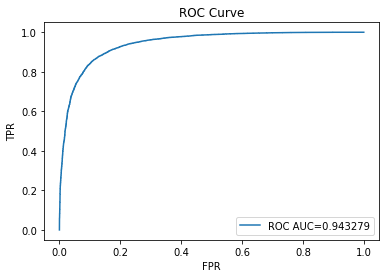

In [10]:
y_pred = clf.predict_proba(test[variables])[:, 1]

plot_metrics(test['signal'], y_pred)
test.shape, y_pred.shape

ROC AUC is just a part of the solution, the classifier:

- output should also not be correlated with the mass
- should perform similarily on MC and real data of the normalisation channel

### Mass correlation check

In [11]:
df_corr_check = pandas.read_csv("reference/check_correlation.csv")

In [12]:
df_corr_check.shape

(5514, 48)

In [13]:
y_pred = clf.predict(df_corr_check[variables])

In [14]:
def efficiencies(features, thresholds=None, mask=None, bins=30, labels_dict=None, ignored_sideband=0.0,
                     errors=False, grid_columns=2):
        """
        Efficiencies for spectators
        :param features: using features (if None then use classifier's spectators)
        :type features: None or list[str]
        :param bins: bins for histogram
        :type bins: int or array-like
        :param mask: mask for data, which will be used
        :type mask: None or numbers.Number or array-like or str or function(pandas.DataFrame)
        :param list[float] thresholds: thresholds on prediction
        :param bool errors: if True then use errorbar, else interpolate function
        :param labels_dict: label -- name for class label
            if None then {0: 'bck', '1': 'signal'}
        :type labels_dict: None or OrderedDict(int: str)
        :param int grid_columns: count of columns in grid
        :param float ignored_sideband: (0, 1) percent of plotting data
        :rtype: plotting.GridPlot
        """
        mask, data, class_labels, weight = self._apply_mask(
            mask, self._get_features(features), self.target, self.weight)
        labels_dict = self._check_labels(labels_dict, class_labels)

        plots = []
        for feature in data.columns:
            for name, prediction in self.prediction.items():
                prediction = prediction[mask]
                eff = OrderedDict()
                for label, label_name in labels_dict.items():
                    label_mask = class_labels == label
                    eff[label_name] = utils.get_efficiencies(prediction[label_mask, label],
                                                             data[feature][label_mask].values,
                                                             bins_number=bins,
                                                             sample_weight=weight[label_mask],
                                                             thresholds=thresholds, errors=errors,
                                                             ignored_sideband=ignored_sideband)

                for label_name, eff_data in eff.items():
                    if errors:
                        plot_fig = plotting.ErrorPlot(eff_data)
                    else:
                        plot_fig = plotting.FunctionsPlot(eff_data)
                    plot_fig.xlabel = feature
                    plot_fig.ylabel = 'Efficiency for {}'.format(name)
                    plot_fig.title = '{} flatness'.format(label_name)
                    plot_fig.ylim = (0, 1)
                    plots.append(plot_fig)

        return plotting.GridPlot(grid_columns, *plots)

In [15]:
def check_arrays(*arrays):
    """
    Left for consistency, version of `sklearn.validation.check_arrays`
    :param list[iterable] arrays: arrays with same length of first dimension.
    """
    assert len(arrays) > 0, 'The number of array must be greater than zero'
    checked_arrays = []
    shapes = []
    for arr in arrays:
        if arr is not None:
            checked_arrays.append(numpy.array(arr))
            shapes.append(checked_arrays[-1].shape[0])
        else:
            checked_arrays.append(None)
    assert numpy.sum(numpy.array(shapes) == shapes[0]) == len(shapes), 'Different shapes of the arrays {}'.format(
        shapes)
    return checked_arrays

In [16]:
def get_efficiencies(prediction, spectator, sample_weight=None, bins_number=20,
                     thresholds=None, errors=False, ignored_sideband=0.0):
    """
    Construct efficiency function dependent on spectator for each threshold
    Different score functions available: Efficiency, Precision, Recall, F1Score,
    and other things from sklearn.metrics
    :param prediction: list of probabilities
    :param spectator: list of spectator's values
    :param bins_number: int, count of bins for plot
    :param thresholds: list of prediction's threshold
        (default=prediction's cuts for which efficiency will be [0.2, 0.4, 0.5, 0.6, 0.8])
    :return:
        if errors=False
        OrderedDict threshold -> (x_values, y_values)
        if errors=True
        OrderedDict threshold -> (x_values, y_values, y_err, x_err)
        All the parts: x_values, y_values, y_err, x_err are numpy.arrays of the same length.
    """
    prediction, spectator, sample_weight = \
        check_arrays(prediction, spectator, sample_weight)

    spectator_min, spectator_max = weighted_quantile(spectator, [ignored_sideband, (1. - ignored_sideband)])
    mask = (spectator >= spectator_min) & (spectator <= spectator_max)
    spectator = spectator[mask]
    prediction = prediction[mask]
    bins_number = min(bins_number, len(prediction))
    sample_weight = sample_weight if sample_weight is None else numpy.array(sample_weight)[mask]

    if thresholds is None:
        thresholds = [weighted_quantile(prediction, quantiles=1 - eff, sample_weight=sample_weight)
                      for eff in [0.2, 0.4, 0.5, 0.6, 0.8]]

    binner = Binner(spectator, bins_number=bins_number)
    if sample_weight is None:
        sample_weight = numpy.ones(len(prediction))
    bins_data = binner.split_into_bins(spectator, prediction, sample_weight)

    bin_edges = numpy.array([spectator_min] + list(binner.limits) + [spectator_max])
    xerr = numpy.diff(bin_edges) / 2.
    result = OrderedDict()
    for threshold in thresholds:
        x_values = []
        y_values = []
        N_in_bin = []
        for num, (masses, probabilities, weights) in enumerate(bins_data):
            y_values.append(numpy.average(probabilities > threshold, weights=weights))
            N_in_bin.append(numpy.sum(weights))
            if errors:
                x_values.append((bin_edges[num + 1] + bin_edges[num]) / 2.)
            else:
                x_values.append(numpy.mean(masses))

        x_values, y_values, N_in_bin = check_arrays(x_values, y_values, N_in_bin)
        if errors:
            result[threshold] = (x_values, y_values, numpy.sqrt(y_values * (1 - y_values) / N_in_bin), xerr)
        else:
            result[threshold] = (x_values, y_values)
    return result

In [17]:
def weighted_quantile(array, quantiles, sample_weight=None, array_sorted=False, old_style=False):
    """Computing quantiles of array. Unlike the numpy.percentile, this function supports weights,
    but it is inefficient and performs complete sorting.
    :param array: distribution, array of shape [n_samples]
    :param quantiles: floats from range [0, 1] with quantiles of shape [n_quantiles]
    :param sample_weight: optional weights of samples, array of shape [n_samples]
    :param array_sorted: if True, the sorting step will be skipped
    :param old_style: if True, will correct output to be consistent with numpy.percentile.
    :return: array of shape [n_quantiles]
    Example:
    >>> weighted_quantile([1, 2, 3, 4, 5], [0.5])
    Out: array([ 3.])
    >>> weighted_quantile([1, 2, 3, 4, 5], [0.5], sample_weight=[3, 1, 1, 1, 1])
    Out: array([ 2.])
    """
    array = numpy.array(array)
    quantiles = numpy.array(quantiles)
    sample_weight = check_sample_weight(array, sample_weight)
    assert numpy.all(quantiles >= 0) and numpy.all(quantiles <= 1), 'Percentiles should be in [0, 1]'

    if not array_sorted:
        array, sample_weight = reorder_by_first(array, sample_weight)

    weighted_quantiles = numpy.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= numpy.sum(sample_weight)
    return numpy.interp(quantiles, weighted_quantiles, array)

In [18]:
def check_sample_weight(y_true, sample_weight):
    """Checks the weights, if None, returns array.
    :param y_true: labels (or any array of length [n_samples])
    :param sample_weight: None or array of length [n_samples]
    :return: numpy.array of shape [n_samples]
    """
    if sample_weight is None:
        return numpy.ones(len(y_true), dtype=numpy.float)
    else:
        sample_weight = numpy.array(sample_weight, dtype=numpy.float)
        assert len(y_true) == len(sample_weight), \
            "The length of weights is different: not {0}, but {1}".format(len(y_true), len(sample_weight))
        return sample_weight

In [19]:
def reorder_by_first(*arrays):
    """
    Applies the same permutation to all passed arrays,
    permutation sorts the first passed array
    """
    arrays = check_arrays(*arrays)
    order = numpy.argsort(arrays[0])
    return [arr[order] for arr in arrays]

class Binner(object):
    def __init__(self, values, bins_number):
        """
        Binner is a class that helps to split the values into several bins.
        Initially an array of values is given, which is then splitted into 'bins_number' equal parts,
        and thus we are computing limits (boundaries of bins).
        """
        percentiles = [i * 100.0 / bins_number for i in range(1, bins_number)]
        self.limits = numpy.percentile(values, percentiles)

    def get_bins(self, values):
        """Given the values of feature, compute the index of bin
        :param values: array of shape [n_samples]
        :return: array of shape [n_samples]
        """
        return numpy.searchsorted(self.limits, values)

    def set_limits(self, limits):
        """Change the thresholds inside bins."""
        self.limits = limits

    @property
    def bins_number(self):
        """:return: number of bins"""
        return len(self.limits) + 1

    def split_into_bins(self, *arrays):
        """
        :param arrays: data to be splitted, the first array corresponds
        :return: sequence of length [n_bins] with values corresponding to each bin.
        """
        values = arrays[0]
        for array in arrays:
            assert len(array) == len(values), "passed arrays have different length"
        bins = self.get_bins(values)
        result = []
        for bin in range(len(self.limits) + 1):
            indices = bins == bin
            result.append([numpy.array(array)[indices] for array in arrays])
        return result
from collections import OrderedDict

In [20]:
eff = get_efficiencies(y_pred, df_corr_check.mass, thresholds=[0.5]) #, thresholds=[0.2, 0.4, 0.5, 0.6, 0.8])

In [21]:
eff.keys()

odict_keys([0.5])

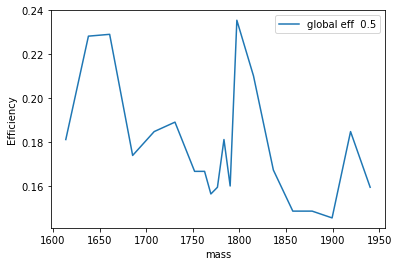

In [22]:
for label_name, eff_data in eff.items():
    pyplot.plot(eff_data[0], eff_data[1], label="global eff  %.1f" % label_name)
pyplot.xlabel('mass')
pyplot.ylabel('Efficiency')
pyplot.legend();

In [23]:
from utils import check_correlation

In [24]:
corr_metric = check_correlation(y_pred, df_corr_check['mass'])
print (corr_metric)

0.00016970194719090125


## MC vs Real difference

In [25]:
df_agreement = pandas.read_csv('reference/check_agreement.csv')

In [26]:
from sklearn.utils.validation import column_or_1d
def get_ks_metric(df_agree, df_test):
    sig_ind = df_agree[df_agree['signal'] == 1].index
    bck_ind = df_agree[df_agree['signal'] == 0].index

    mc_prob = numpy.array(df_test.loc[sig_ind]['prediction'])
    mc_weight = numpy.array(df_agree.loc[sig_ind]['weight'])
    data_prob = numpy.array(df_test.loc[bck_ind]['prediction'])
    data_weight = numpy.array(df_agree.loc[bck_ind]['weight'])
    val, agreement_metric = check_agreement_ks_sample_weighted(data_prob, mc_prob, data_weight, mc_weight)
    return agreement_metric['ks']

In [27]:
def check_agreement_ks_sample_weighted (data_prediction, mc_prediction, weights_data, weights_mc):
    data_prediction, weights_data = map(column_or_1d, [data_prediction, weights_data])
    mc_prediction, weights_mc = map(column_or_1d, [mc_prediction, weights_mc])

    assert numpy.all(data_prediction >= 0.) and numpy.all(data_prediction <= 1.), 'error in prediction'
    assert numpy.all(mc_prediction >= 0.) and numpy.all(mc_prediction <= 1.), 'error in prediction'

    weights_data = weights_data / numpy.sum(weights_data)
    weights_mc = weights_mc / numpy.sum(weights_mc)

    data_neg = data_prediction[weights_data < 0]
    weights_neg = -weights_data[weights_data < 0]
    mc_prediction = numpy.concatenate((mc_prediction, data_neg))
    weights_mc = numpy.concatenate((weights_mc, weights_neg))
    data_prediction = data_prediction[weights_data >= 0]
    weights_data = weights_data[weights_data >= 0]

    assert numpy.all(weights_data >= 0) and numpy.all(weights_mc >= 0)
    assert numpy.allclose(weights_data.sum(), weights_mc.sum())

    weights_data /= numpy.sum(weights_data)
    weights_mc /= numpy.sum(weights_mc)

    fpr, tpr, _ = roc_curve_splitted(data_prediction, mc_prediction, weights_data, weights_mc)

    Dnm = numpy.max(numpy.abs(fpr - tpr))
    Dnm_part = numpy.max(numpy.abs(fpr - tpr)[fpr + tpr < 1])

    result = {'ks': Dnm, 'ks_part': Dnm_part}
    return Dnm_part < 0.03, result

In [28]:
df_agreement.columns

Index(['id', 'LifeTime', 'dira', 'FlightDistance', 'FlightDistanceError', 'IP',
       'IPSig', 'VertexChi2', 'pt', 'DOCAone', 'DOCAtwo', 'DOCAthree',
       'IP_p0p2', 'IP_p1p2', 'isolationa', 'isolationb', 'isolationc',
       'isolationd', 'isolatione', 'isolationf', 'iso', 'CDF1', 'CDF2', 'CDF3',
       'ISO_SumBDT', 'p0_IsoBDT', 'p1_IsoBDT', 'p2_IsoBDT', 'p0_track_Chi2Dof',
       'p1_track_Chi2Dof', 'p2_track_Chi2Dof', 'p0_IP', 'p1_IP', 'p2_IP',
       'p0_IPSig', 'p1_IPSig', 'p2_IPSig', 'p0_pt', 'p1_pt', 'p2_pt', 'p0_p',
       'p1_p', 'p2_p', 'p0_eta', 'p1_eta', 'p2_eta', 'SPDhits', 'signal',
       'weight'],
      dtype='object')

In [29]:
df_agreement[variables].head()

,DOCAtwo,isolationd,p1_p,p2_track_Chi2Dof,ISO_SumBDT,IP_p0p2,p2_pt,p0_IsoBDT,p2_IP,IP_p1p2,...,p1_pt,isolationa,FlightDistanceError,p0_track_Chi2Dof,isolatione,p1_IP,p1_eta,p2_IPSig,CDF3,isolationb
0,0.084005,2.0,6380.673828,1.487057,-0.207475,0.185107,834.562378,-0.019306,0.426797,0.214719,...,468.645721,8,0.229196,0.606178,1.0,0.474925,3.302978,8.853514,0.179091,6
1,0.044154,1.0,64480.023438,1.336784,-0.659644,0.039357,2861.309814,-0.278330,0.123877,0.217507,...,7547.703613,5,0.517488,1.900118,1.0,0.260311,2.834816,7.737038,0.584701,6
2,0.106614,0.0,3921.181641,0.798658,-0.399239,0.335788,932.128235,-0.115879,1.290409,0.885080,...,317.579529,2,0.219291,0.660675,0.0,1.163556,3.204923,44.521961,0.295038,2
3,0.038642,0.0,13221.149414,0.938619,-0.821041,0.076522,2617.248291,-0.208248,0.166646,0.068347,...,1650.837524,4,0.167886,0.770563,0.0,0.164411,2.769762,9.630725,0.533615,4
4,0.020872,0.0,46903.394531,1.123868,-1.116815,0.249906,4763.682617,-0.328938,0.112430,0.139937,...,9657.492188,0,0.284975,1.080559,0.0,0.230584,2.262732,7.389726,0.926410,1


In [30]:
def compute_ks(data_prediction, mc_prediction, weights_data, weights_mc):
    """
    Compute Kolmogorov-Smirnov (ks) distance between real data predictions cdf and Monte Carlo one.
    :param data_prediction: array-like, real data predictions
    :param mc_prediction: array-like, Monte Carlo data predictions
    :param weights_data: array-like, real data weights
    :param weights_mc: array-like, Monte Carlo weights
    :return: ks value
    """
    assert len(data_prediction) == len(weights_data), 'Data length and weight one must be the same'
    assert len(mc_prediction) == len(weights_mc), 'Data length and weight one must be the same'

    data_prediction, mc_prediction = numpy.array(data_prediction), numpy.array(mc_prediction)
    weights_data, weights_mc = numpy.array(weights_data), numpy.array(weights_mc)

    assert numpy.all(data_prediction >= 0.) and numpy.all(data_prediction <= 1.), 'Data predictions are out of range [0, 1]'
    assert numpy.all(mc_prediction >= 0.) and numpy.all(mc_prediction <= 1.), 'MC predictions are out of range [0, 1]'

    weights_data /= numpy.sum(weights_data)
    weights_mc /= numpy.sum(weights_mc)

    fpr, tpr = __roc_curve_splitted(data_prediction, mc_prediction, weights_data, weights_mc)

    Dnm = numpy.max(numpy.abs(fpr - tpr))
    return Dnm

In [31]:
from sklearn.metrics import roc_curve
def __roc_curve_splitted(data_zero, data_one, sample_weights_zero, sample_weights_one):
    """
    Compute roc curve
    :param data_zero: 0-labeled data
    :param data_one:  1-labeled data
    :param sample_weights_zero: weights for 0-labeled data
    :param sample_weights_one:  weights for 1-labeled data
    :return: roc curve
    """
    labels = [0] * len(data_zero) + [1] * len(data_one)
    weights = numpy.concatenate([sample_weights_zero, sample_weights_one])
    data_all = numpy.concatenate([data_zero, data_one])
    fpr, tpr, _ = roc_curve(labels, data_all, sample_weight=weights)
    return fpr, tpr

In [32]:
agreement_probs = clf.predict_proba(df_agreement[variables])[:, 1]

ks = compute_ks(
    agreement_probs[df_agreement['signal'].values == 0],
    agreement_probs[df_agreement['signal'].values == 1],
    df_agreement[df_agreement['signal'] == 0]['weight'].values,
    df_agreement[df_agreement['signal'] == 1]['weight'].values)
print ('KS metric:', ks, "is OK:", ks < 0.09)

KS metric: 0.16960350841310906 is OK: False


In [33]:
def plot_ks(X_agreement, y_pred):
    sig_ind = X_agreement[X_agreement['signal'] == 1].index
    bck_ind = X_agreement[X_agreement['signal'] == 0].index

    mc_prob = y_pred[sig_ind]
    mc_weight = numpy.array(X_agreement.loc[sig_ind]['weight'])
    data_prob = y_pred[bck_ind]
    data_weight = numpy.array(X_agreement.loc[bck_ind]['weight'])
    inds = data_weight < 0
    mc_weight = numpy.array(list(mc_weight) + list(-data_weight[inds]))
    mc_prob = numpy.array(list(mc_prob) + list(data_prob[inds]))
    data_prob = data_prob[data_weight >= 0]
    data_weight = data_weight[data_weight >= 0]
    hist(data_prob, weights=data_weight, color='r', histtype='step', density=True, bins=60, label='data')
    hist(mc_prob, weights=mc_weight, color='b', histtype='step', density=True, bins=60, label='mc')
    xlabel("prediction")
    legend(loc=2)
    show()

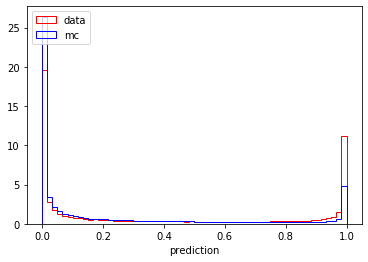

In [34]:
plot_ks(df_agreement, agreement_probs)

### Adding noise to see if there is improvement with the agreement

In [35]:
def add_noise(array, level=0.15, random_seed=34):
    numpy.random.seed(random_seed)
    return level * numpy.random.random(size=array.size) + (1 - level) * array

In [36]:
agreement_probs_noise = add_noise(clf.predict_proba(df_agreement[variables])[:, 1])

In [37]:
ks_noise = compute_ks(
    agreement_probs_noise[df_agreement['signal'].values == 0],
    agreement_probs_noise[df_agreement['signal'].values == 1],
    df_agreement[df_agreement['signal'] == 0]['weight'].values,
    df_agreement[df_agreement['signal'] == 1]['weight'].values)
print ('KS metric:', ks_noise, "is OK:", ks_noise < 0.09)

KS metric: 0.09616629669652388 is OK: False


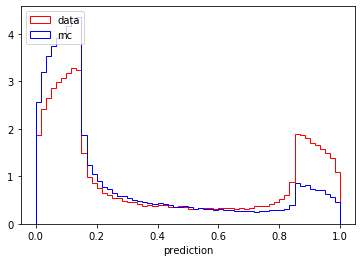

In [38]:
plot_ks(df_agreement, agreement_probs_noise)

### Check ROC with noise

In [39]:
test.shape

(20266, 51)

((20266, 51), (20266,))

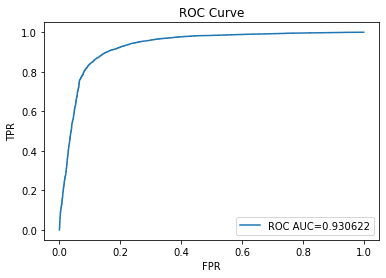

In [40]:
y_pred = add_noise(clf.predict_proba(test[variables])[:, 1])

plot_metrics(test['signal'], y_pred)
test.shape, y_pred.shape

## Train the model using the entire training set

In [41]:
%time clf.fit(train_ada[variables], train_ada['signal'])

CPU times: user 1min 29s, sys: 162 ms, total: 1min 30s
Wall time: 1min 30s


AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=19,
                                                         max_features=10,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=40,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

### Compute prediction for test set and add noise

In [42]:
y_pred = add_noise(clf.predict_proba(test_ada[variables])[:, 1])

## Prepare submission file

In [43]:
def save_submission(y_pred, index, filename='result'):
    sep = ','
    filename = '{}.csv.gz'.format(filename)
    pandas.DataFrame({'id': index, 'prediction': y_pred}).to_csv(
                filename, sep=sep, index=False, compression='gzip')
    print ("Saved file: ", filename, "\nShape:", (y_pred.shape[0], 2))
    return filename

In [44]:
save_submission(y_pred, test_ada.index, "sample_submission")

Saved file:  sample_submission.csv.gz 
Shape: (855819, 2)


'sample_submission.csv.gz'